# Получение модели с помощью CatBoost

## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

## Обучение модели

In [3]:
# Загрузка данных
df = pd.read_csv("../Data/data.csv")

In [4]:
# Типы переменных
df.dtypes

vessel_type         object
L                  float64
B                  float64
d                  float64
DW                 float64
speed              float64
cargo_amount         int64
cost_per_mile      float64
cargo_demand         int64
cargo_value          int64
cargo_fragility      int64
cargo_danger         int64
sea_route            int64
wind_strength        int64
sea_state            int64
target             float64
dtype: object

In [5]:
X = df.drop("target", axis=1)
y = df["target"]

In [6]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1186, 15)
y shape: (1186,)


In [7]:
# Разбивка данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [19]:
# Числовые переменные
X_col = ['L', 'B', 'd', 'DW', 'speed', 'cargo_amount',
         'cost_per_mile', 'sea_route']
# Категориальные переменные
cat_features = ['vessel_type', 'cargo_demand',
                'cargo_value', 'cargo_fragility',
                'cargo_danger', 'wind_strength',
                'sea_state']
# Зависимая переменная
y_col = ['target']

In [126]:
# Создание модели
model = CatBoostRegressor(random_seed=42, verbose=100, task_type="GPU",
                          cat_features=cat_features, loss_function="RMSE",
                          early_stopping_rounds=300, iterations=4000,
                          learning_rate=0.05)

In [127]:
# Обучение модели
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 7533.4015902	test: 9274.5309323	best: 9274.5309323 (0)	total: 28.5ms	remaining: 1m 53s
100:	learn: 1385.8665281	test: 2614.0796296	best: 2614.0796296 (100)	total: 2.77s	remaining: 1m 47s
200:	learn: 1263.6857407	test: 2458.6733276	best: 2458.5394038 (198)	total: 4.98s	remaining: 1m 34s
300:	learn: 1054.8188848	test: 2209.6792521	best: 2208.8323225 (297)	total: 7.3s	remaining: 1m 29s
400:	learn: 855.2178759	test: 1944.0394060	best: 1944.0394060 (400)	total: 10.3s	remaining: 1m 32s
500:	learn: 788.0724787	test: 1836.5156879	best: 1836.5156879 (500)	total: 13.1s	remaining: 1m 31s
600:	learn: 728.9293071	test: 1774.7362871	best: 1774.7362871 (600)	total: 15.7s	remaining: 1m 28s
700:	learn: 672.8625082	test: 1712.3190489	best: 1712.3190489 (700)	total: 18.5s	remaining: 1m 27s
800:	learn: 628.1604547	test: 1652.5708245	best: 1652.0826811 (790)	total: 21.2s	remaining: 1m 24s
900:	learn: 620.1205006	test: 1647.8246450	best: 1647.8246450 (900)	total: 23.8s	remaining: 1m 21s
1000:	lear

## Визуализация модели

In [128]:
importances_df = pd.DataFrame({"names": model.feature_names_, "scores": model.feature_importances_}).sort_values("scores", ascending=True)

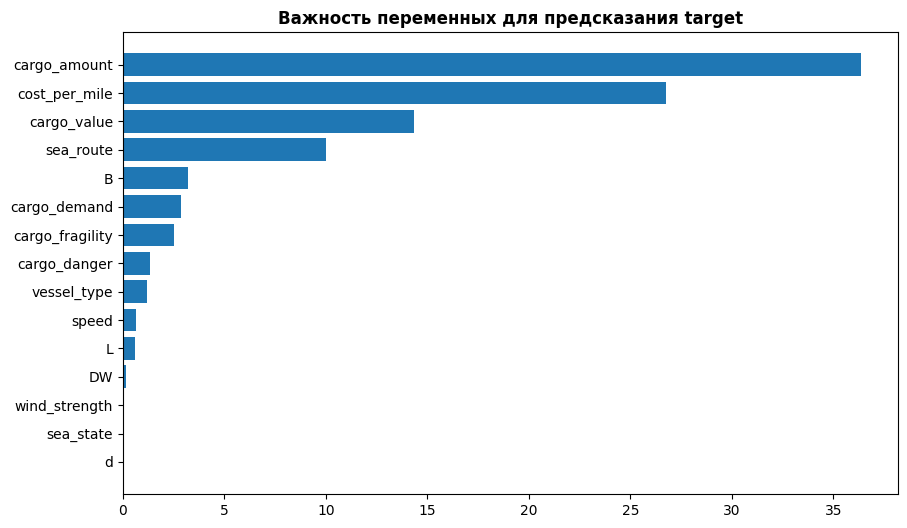

In [129]:
figure = plt.figure(figsize=(10, 6))
plt.barh(range(len(importances_df.iloc[:, 0])), importances_df.iloc[:, 1])
plt.yticks(range(len(importances_df.iloc[:, 0])), importances_df.iloc[:, 0])
plt.title("Важность переменных для предсказания target", fontweight="bold")
# Сохранение графика

plt.savefig("../Images/Graphs/Feature_importances_CatBoost_Model.png", dpi=199)

plt.show()

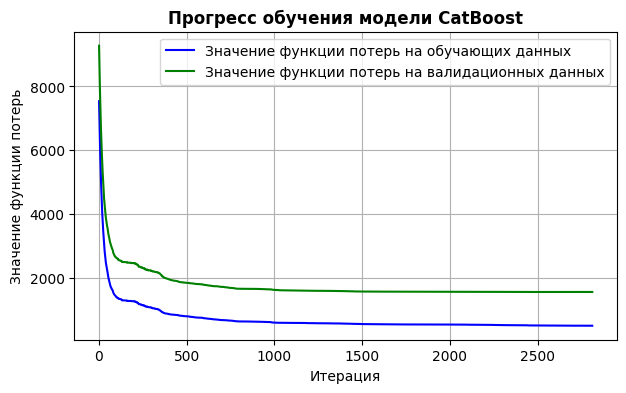

In [16]:
# Информация о значениях RMSE на обучающих данных и валидационных
evals_result = model.get_evals_result()
train_loss = evals_result['learn']["RMSE"]
test_loss = evals_result['validation']["RMSE"]


# Построение графика обучения модели CatBoost
iterations = np.arange(1, len(train_loss) + 1)
 
plt.figure(figsize=(7, 4))
plt.plot(iterations, train_loss, label='Значение функции потерь на обучающих данных', color='blue')
plt.plot(iterations, test_loss, label='Значение функции потерь на валидационных данных', color='green')
plt.xlabel('Итерация')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения модели CatBoost', fontweight="bold")
plt.legend()
plt.grid()
plt.savefig("../Images/Graphs/Training_Progress_CatBoost_Model_v2.png", dpi=199)
plt.show()

## Информация о модели

In [132]:
print(f"Лучшее качество модели получено на {model.best_iteration_} итерации")
print(f"RMSE на обучающих данных = {model.best_score_['learn']['RMSE']:.2f}")
print(f"RMSE на валидационных данных = {model.best_score_['validation']['RMSE']:.2f}")

Лучшее качество модели получено на 2511 итерации
RMSE на обучающих данных = 493.70
RMSE на валидационных данных = 1550.43


## Сохранение модели

In [133]:
model.save_model("../catboost_info/model_weights.cbm")

## Загрузка модели

In [13]:
model = CatBoostRegressor().load_model("../catboost_info/model_weights.cbm")

In [14]:
# Точность модели с помощью расчета R2 метрики
preds = model.predict(X_test)
r2_result = r2_score(y_test, preds)

print(f"R2 CatBoost модели = {r2_result:.2f}")

R2 CatBoost модели = 0.99
